# Week 9, Lab \#8

*March 13, 2024*

In this course we've been working with vegetation indices like the Normalized Difference Greenness Index (NDGI) and Normalized Difference Vegetation Index (NDVI). These vegetation indices (VI) are sensitive to changes in green leaf cover or vigor and can be used to quantify the status of green vegetation. 

If a time series of VI were available, we could, in theory, quantify changes in green vegetation cover or vigor over time. This is an important application of remote sensing because terrestrial vegetation may serve as an indicator of several trends in the terrestrial biosphere:

- Changes in water availability (soil moisture) will affect vegetation in semi-arid regions.
- Changes in temperature also affect vegetation status: Short-term extremes like heat waves can damage vegetation while long-term warming trends might extend the growing season and improve vegetation growth or vigor at high latitudes or high elevations.
- At high latitudes, in particular, warmer conditions and thawing soils have led to the encroachment of woody shrubs on former grasslands; the shrubs tend to have more and greener leaf cover, so this can show up as an increase in greenness.
- Increasing CO$_2$ levels in the atmosphere can also lead to a "fertilization effect," whereby vegetation, particularly trees, can absorb more carbon from the atmosphere while losing less water, potentially accelerating their growth rates.

**Today, we'll use [NDVI data from the MODIS sensor aboard the Terra satellite](https://lpdaac.usgs.gov/products/mod13a1v061/) to analyze greenness trends over time. We'll look at a single MODIS tile that shows much of Alberta and British Columbia, Canada.**

[**Download the data and extract it to a folder where you can access it from this Notebook.**](http://files.ntsg.umt.edu/data/GIS_Programming/data/MOD13A1_Alberta.zip)

## The EOS-HDF4 Format

Before we get started analyzing the data, we need to familarize ourselves with the data format.

The MODIS MOD13A1 product that we're using today is currently only available in a hierarchical data file formt, but not one that we've seen before: They're stored as EOS-HDF4 files, a special NASA file format based on an older HDF standard (HDF4). EOS-HDF4 can be difficult to work with and depending on how the file was created and the version of GDAL we have installed, we may not be able to read spatial information from the file. 

`gdal` can read from HDF4 (and HDF5) files. However, for hierarchical file types, there could be multiple different datasets contained within.

In [1]:
from osgeo import gdal

hdf = gdal.Open('data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf')
for data in hdf.GetSubDatasets():
    print(data[0])

HDF4_EOS:EOS_GRID:"data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf":MODIS_Grid_16DAY_500m_VI:"500m 16 days NDVI"
HDF4_EOS:EOS_GRID:"data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf":MODIS_Grid_16DAY_500m_VI:"500m 16 days EVI"
HDF4_EOS:EOS_GRID:"data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf":MODIS_Grid_16DAY_500m_VI:"500m 16 days VI Quality"
HDF4_EOS:EOS_GRID:"data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf":MODIS_Grid_16DAY_500m_VI:"500m 16 days red reflectance"
HDF4_EOS:EOS_GRID:"data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf":MODIS_Grid_16DAY_500m_VI:"500m 16 days NIR reflectance"
HDF4_EOS:EOS_GRID:"data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf":MODIS_Grid_16DAY_500m_VI:"500m 16 days blue reflectance"
HDF4_EOS:EOS_GRID:"data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf":MODIS_Grid_16DAY_500m_VI:"500m 16 days MIR reflectance"
HDF4_EOS:EOS_GRID:"data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf":MODIS_Grid_16DAY_500m_VI:"500m 16 days view zenith angle"
HDF4_EOS:

First, let's close the dataset we just opened.

In [2]:
hdf = None

These **subdatasets** need to be loaded in a special way. We use *string formatting* in Python, below, to embed the filename into the larger dataset name, as GDAL expects.

In [3]:
some_string = 'good'
f'Have a {some_string} Lab!'

'Have a good Lab!'

In [4]:
'Have a {adjective} Lab!'.format(adjective = some_string)

'Have a good Lab!'

In [5]:
filename = 'data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf'

ndvi = gdal.Open(f'HDF4_EOS:EOS_GRID:{filename}:MODIS_Grid_16DAY_500m_VI:"500m 16 days NDVI"')
ndvi.ReadAsArray()

array([[ -45,   -4, -143, ..., 6890, 7162, 6775],
       [  31,  223,  361, ..., 6812, 7331, 7159],
       [ 223, 2591, 4009, ..., 7167, 7091, 7107],
       ...,
       [6836, 7712, 7554, ..., 8149, 7800, 8000],
       [7323, 7554, 7786, ..., 7800, 7850, 7718],
       [7556, 7701, 6470, ..., 7443, 7592, 7095]], dtype=int16)

It's pretty verbose, but this is how `gdal` handles HDF and netCDF4 files.

## Reading and Plotting MODIS NDVI Data

Similar to the NDGI, the Normalized Difference Vegetation Index (NDVI) is a measure of green vegetation cover and vigor. NDVI is superior to NDGI, however, because it incorporates data on near-infrared (NIR) reflectance, which is more physically related to green leaves than visible green reflectance. This is because chlorophyll is strongly absorbing of Red light while the internal structure of leaves and stems tends to be highly reflective of NIR light.

$$
\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}
$$

Because NDVI is normalized, when correctly calculated the values fall between -1 and +1, inclusive, where positive values generally correspond to increasing vegetation greenness and negative values generally correspond to non-vegetation cover.

**The MODIS MOD13A1 product also includes a "pixel reliability" band that summarizes the state of each pixel** (see Table 4 of the User Guide).

In [6]:
qa = gdal.Open(f'HDF4_EOS:EOS_GRID:{filename}:MODIS_Grid_16DAY_500m_VI:"500m 16 days pixel reliability"')
qa = qa.ReadAsArray()
qa = qa.astype('uint8')

In [7]:
import numpy as np

np.unique(qa)

array([  0,   1,   2,   3, 255], dtype=uint8)

This is a kind of quality assurance (QA) band and the values are described below.

Value | Summary key   | Description                              |
------|--------------:|-----------------------------------------:|
0     | Good data     | Use with confidence                      |
1     | Marginal data | Useful, but look at other QA information |
2     | Snow/Ice      | Target covered with snow or ice          |
3     | Cloudy        | Target covered by cloud                  |
255   | No Data       | Not processed                            |

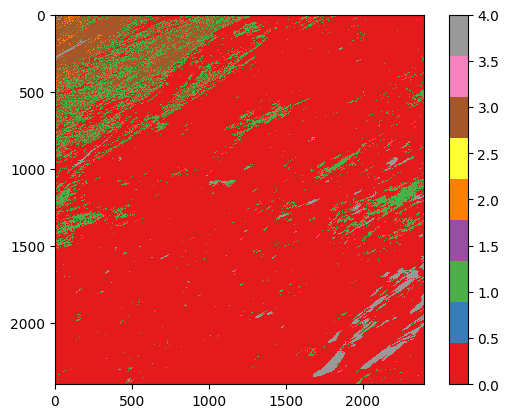

In [8]:
from matplotlib import pyplot

pyplot.imshow(np.where(qa == 255, 4, qa), cmap = 'Set1', interpolation = 'nearest')
pyplot.colorbar()

---

## Problem 8.1: Plotting MODIS NDVI

**Write a Python function (using `def` keyword) called `process_ndvi()` that:**

1. Accepts an MOD13A1 filename as an argument;
2. Opens the MOD13A1 file;
3. Reads in the NDVI and the "pixel reliability" data;
4. Sets pixels where the pixel reliability is not 0 or 1 to `NaN` (i.e., only "Good" or "Marginal" pixels should be used);
5. Returns a NumPy array of the masked NDVI data.

**Hint:** Make sure you know *how* to use these data! Think about NoData, data types, and valid ranges. [Take a look at the User Guide,](http://files.ntsg.umt.edu/data/GIS_Programming/docs/MOD13_User_Guide_V61.pdf) particularly Table 1 on Page 9.

**Hint:** As suggested in the previous hint, think particularly about: Do the data need to be re-scaled?

The result should look something like this:

In [9]:
def process_ndvi(filename):
    # read NDVI data
    ndvi = gdal.Open(f'HDF4_EOS:EOS_GRID:{filename}:MODIS_Grid_16DAY_500m_VI:"500m 16 days NDVI"')
    ndvi = ndvi.ReadAsArray().astype(np.float32)
    # read pixel reliability data
    qa = gdal.Open(f'HDF4_EOS:EOS_GRID:{filename}:MODIS_Grid_16DAY_500m_VI:"500m 16 days pixel reliability"')
    qa = qa.ReadAsArray().astype(np.float32)
    # Set qa pixels != 0 or 1 to np.nan
    arr = np.where((qa != 1) & (qa != 0), np.nan, ndvi)
    # Multiply ndvi by scale factor 0.0001
    result = arr * 0.0001
    # Return
    return result

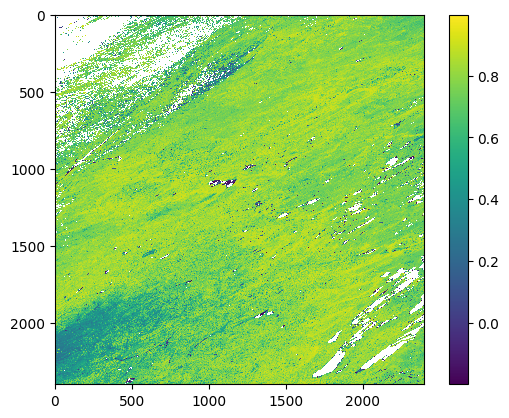

In [10]:
import matplotlib.pyplot as plt

result = process_ndvi('data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf')

plt.imshow(result, interpolation = 'nearest')
plt.colorbar()

---

Because this image is in the MODIS Sinusoidal projection, it's kind of hard to visualize, so I made this re-projected, north-up image (Lambert Conformal Conic projection) in QGIS, showing the land-cover distribution in this MODIS tile. Lake Winnepegosis can be seen at the lower-right of the image.

![](./assets/MCD12Q1_h11v03.png)

**This is a good start, but there are some very low NDVI values in areas with permanent water bodies.** We also might want to mask out high-elevation areas of ice, snow, or barren rock.

Let's use another MODIS product, MCD12Q1 (source of the land-cover data above), contains a map of land cover that can be used to mask pixels based on their land-cover classification.

## Loading MCD12Q1 Data

MODIS products come as "tiles;" the entire Earth's surface is divided into large tiles and each product has data for each of the tiles, like the MOD13A1 example above. [**Download the corresponding MCD12Q1 tile data here.**](http://files.ntsg.umt.edu/data/GIS_Programming/data/MCD12Q1.A2015001.h11v03.006.hdf)

This is another EOS-HDF4 file with multiple datasets.

In [11]:
lc = gdal.Open('data/MCD12Q1.A2015001.h11v03.006.hdf')
lc.GetSubDatasets()

[('HDF4_EOS:EOS_GRID:"data/MCD12Q1.A2015001.h11v03.006.hdf":MCD12Q1:LC_Type1',
  '[2400x2400] LC_Type1 MCD12Q1 (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"data/MCD12Q1.A2015001.h11v03.006.hdf":MCD12Q1:LC_Type2',
  '[2400x2400] LC_Type2 MCD12Q1 (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"data/MCD12Q1.A2015001.h11v03.006.hdf":MCD12Q1:LC_Type3',
  '[2400x2400] LC_Type3 MCD12Q1 (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"data/MCD12Q1.A2015001.h11v03.006.hdf":MCD12Q1:LC_Type4',
  '[2400x2400] LC_Type4 MCD12Q1 (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"data/MCD12Q1.A2015001.h11v03.006.hdf":MCD12Q1:LC_Type5',
  '[2400x2400] LC_Type5 MCD12Q1 (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"data/MCD12Q1.A2015001.h11v03.006.hdf":MCD12Q1:LC_Prop1_Assessment',
  '[2400x2400] LC_Prop1_Assessment MCD12Q1 (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"data/MCD12Q1.A2015001.h11v03.006.hdf":MCD12Q1:LC_Prop2_Assessment',
  '[2400x2400] LC_Prop2_Assessment MCD12Q1 (8-bit unsi

The land-cover map we'll use today is "Type 5" (global Plant Functional Type or PFT map):

Type                              | Code |
----------------------------------|------|
Water bodies                      | 0    |
Evergreen needleleaf forest (ENF) | 1    |
Evergreen broadleaf forest  (EBF) | 2    |
Deciduous needleleaf forest (DNF) | 3    |
Deciduous broadleaf forest  (DBF) | 4    |
Shrubland                   (SHB) | 5    |
Grasslands                  (GRS) | 6    |
Cereal Croplands            (CCR) | 7    |
Broadleaf Croplands         (BCR) | 8    |
Urban or built-up                 | 9    |
Snow or ice                       | 10   |
Barren                            | 11   |

In [12]:
lc.GetSubDatasets()[4]

('HDF4_EOS:EOS_GRID:"data/MCD12Q1.A2015001.h11v03.006.hdf":MCD12Q1:LC_Type5',
 '[2400x2400] LC_Type5 MCD12Q1 (8-bit unsigned integer)')

So, let's close this file and re-open the subdataset that we want.

In [13]:
lc = None
lc = gdal.Open('HDF4_EOS:EOS_GRID:"data/MCD12Q1.A2015001.h11v03.006.hdf":MCD12Q1:LC_Type5')
lc.ReadAsArray()

array([[11, 11, 11, ...,  1,  1,  1],
       [11,  6,  6, ...,  1,  1,  1],
       [ 6,  6,  6, ...,  1,  1,  1],
       ...,
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  4],
       [ 7,  7,  7, ...,  4,  4,  1]], dtype=uint8)

**In this land-cover scheme, water pixels have a value of zero, so we can make a water mask simply by selecting those pixels.**

In [14]:
water = np.where(lc.ReadAsArray() == 0, 1, 0)

In `water`, the water pixels have a value of `1` while all others have a value of `0`. Since we only have two values, let's make sure the data type for `water` is appropriate.

In [15]:
water.dtype

dtype('int32')

**Whoa, that data type can store a lot more numbers than just 0 or 1;** let's set the data type to 8-bit unsigned integer instead.

In [16]:
water = water.astype(np.uint8)

Now we can plot the mask.

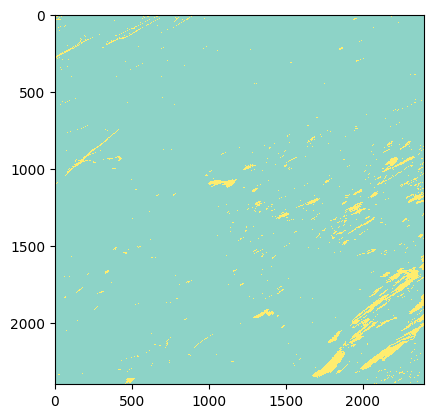

In [17]:
pyplot.imshow(water, cmap = 'Set3', interpolation = 'nearest')

---

## Problem 8.2: Applying a Land-Cover Mask

Using the MODIS MCD12Q1 data, create a single NumPy array that can be used to mask out:

- Water bodies (0)
- Ice or snow (10)
- Urban areas (9)
- Barren pixels (11)

The array should be a binary (0 or 1) array where 1 corresponds to the undesirable land-cover classes.

In [19]:
# Create a binary NumPy array where 1 represents the four unwanted land classes and 0 represents everything else.
my_mask = np.where((lc.ReadAsArray() == 0) |
                   (lc.ReadAsArray() == 9) |
                   (lc.ReadAsArray() == 10) |
                   (lc.ReadAsArray() == 11),
                   1, 0
                  )
my_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**Write a Python script (`*.py` file) that combines everything you've done so far:**

1. Reads in a single MOD13A1 image.
2. Masks out pixels according to their "pixel reliability"
3. Masks out pixels from undesirable land-cover classes (see above).

**These steps must be implemented as one or more Python functions (using `def` keyword).** The simplest template for your Python script would be something like:

```py
NDVI_FILE = ''
LAND_COVER_FILE = ''

def main():
    # Steps 1-3 implemented here
    

if __name__ == '__main__':
    main()
```

**Copy the Python script's contents into a code block in this Notebook for submission.**

---

In [ ]:
import numpy as np
from osgeo import gdal

NDVI_FILE = 'data/MOD13A1.A2000193.h11v03.061.2020051154615.hdf'
LANDCOVER_FILE = 'data/MCD12Q1.A2015001.h11v03.006.hdf'

@profile
def process_ndvi(ndvi_file, landcover_file):
    # read NDVI data
    ndvi = gdal.Open(f'HDF4_EOS:EOS_GRID:{ndvi_file}:MODIS_Grid_16DAY_500m_VI:"500m 16 days NDVI"')
    ndvi = ndvi.ReadAsArray().astype(np.float32)
    # read pixel reliability data
    qa = gdal.Open(f'HDF4_EOS:EOS_GRID:{ndvi_file}:MODIS_Grid_16DAY_500m_VI:"500m 16 days pixel reliability"')
    qa = qa.ReadAsArray().astype(np.float32)
    # Set qa pixels != 0 or 1 to np.nan
    arr = np.where((qa != 1) & (qa != 0), np.nan, ndvi)
    # read landcover data
    lc = gdal.Open(f'HDF4_EOS:EOS_GRID:{landcover_file}:MCD12Q1:LC_Type5')
    lc = lc.ReadAsArray().astype(np.uint8)
    # Create landcover mask
    landcover_mask = np.where((lc == 0) | (lc == 9) | (lc == 10) | (lc == 11), 1, 0)
    # Use landcover mask
    arr = np.where(landcover_mask == 1, np.nan, arr)
    # Multiply ndvi by scale factor 0.0001
    result = arr * 0.0001
    # Return
    return result

if __name__ == '__main__':
    result = process_ndvi(NDVI_FILE, LANDCOVER_FILE)

## Diagnosing Bottlenecks in Python Code

In a previous class, we saw how multiple Python processes can be used to process raster data in parallel, assuming that our raster processing would be slow if done with a single process.

However, a better plan for your professional Python life, when you think that you might have "slow" code, is to first **profile** your Python code to figure out if and where it's running slow. A **line profiler** is a technique that measures the resources (time and memory) required for each Python statement in your code, helping to identify opportunities to optimize your code.

If you haven't already installed the `line_profiler` module, then type the following into your OSGeo4W Shell and hit ENTER:

```sh
pip install line_profiler
```

Profiling your Python code consists of two steps:

**First, add the `@profile` decorator to the top of each Python function in your Python script (`*.py` file) that you want to get resource statistics about:**

```py
@profile
def some_function():
    ...
    
@profile
def another_function():
    ...
```

A *decorator* in Python is always put on the line before another function definition, pre-prended with the `@` symbol. When the *decorated* function is called, it is actually the *decorator* function that is called first. In this example, `profile()` would be called first and provided with the function `some_function` as its argument. This is how the `line_profiler` module can gather statistics about how `some_function()` executes.

**Second,** from the OSGeo4W Shell, run the line profiler on your script. For example, if your Python script is named `my_script.py`, you would type:

```sh
python -m kernprof -l -v my_script.py
```

**Here's a complete example; the Python script:**

```py
import numpy as np

@profile
def main():
    upper_limit = 1000
    return np.arange(0, upper_limit)
    
    
if __name__ == "__main__":
    main()
```

**And the output from the line profiler (`kernprof`):**

```
C:\Users\Arthur.Endsley>python -m kernprof -l -v temp.py
Wrote profile results to temp.py.lprof
Timer unit: 1e-06 s

Total time: 1.3618e-05 s
File: temp.py
Function: main at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     3                                           @profile
     4                                           def main():
     5         1          1.8      1.8     13.3      upper_limit = 1000
     6         1         11.8     11.8     86.7      return np.arange(0, upper_limit)
```

In this example, we can see that the Python interpreter spent 86.7% of its time on calling `np.arange()` (Line 6) and only 13.3% of its time on creating the variabile `upper_limit` (Line 5). If this wasn't just a toy example, and if we found that the function was running long, we would want to focus any optimization efforts on Line 6, where the interpreter spent the most time.

---

## Problem 8.3: Profiling Your Python Script

**Use the line profiler on the Python script your wrote for Problem 5.2. Copy and paste the output into this Notebook for submission.**

What part of your script takes longest to run?

**Hint:** To copy text from the OSGeo4W Shell: 1) Highlight the text you want to copy; 2) Right-click the *title bar* of the OSGeo4W Shell window; 3) Scroll down to "Edit" and then select "Copy" from the drop-down menu.

---

## Calculating Trends in NDVI

You should now have a script that takes in a MOD13A1 file, masks out pixels based on "pixel reliability," and applies a land-cover type mask. Now we're ready to calculate trends in NDVI!

Remember the `linear_trend()` function we defined in the **"Raster Data Analysis in Python, Part 2"** lesson? Let's make a modification to that function here...

In [20]:
from scipy import stats

def linear_trend3(block, years = np.arange(2000, 2024, 2)):
    '''
    Parameters
    ----------
    block : numpy.ndarray
        An (m x n) array, where m is the number of years
    years : numpy.ndarray
        A 1D NumPy array that represents the years
    '''
    # A fancy way of saying call stats.linregress() in a for loop,
    #    once for each pixel in the block
    return np.array([
        stats.linregress(years, block[:,i])[0]
        for i in range(0, block[0].size)
    ])

We want to iterate over all the MOD13A1 files... Change the following, if necessary, so you can get a list of the MOD13A1 files you downloaded.

In [21]:
import glob

# The * symbol below is a wildcard: It matches 0 or more characters in a filename
file_list = glob.glob('data/MOD13A1*.hdf')
file_list.sort()
file_list

['data\\MOD13A1.A2000193.h11v03.061.2020051154615.hdf',
 'data\\MOD13A1.A2002193.h11v03.061.2020077115203.hdf',
 'data\\MOD13A1.A2004193.h11v03.061.2020196083905.hdf',
 'data\\MOD13A1.A2006193.h11v03.061.2020267140733.hdf',
 'data\\MOD13A1.A2008193.h11v03.061.2021102134531.hdf',
 'data\\MOD13A1.A2010193.h11v03.061.2021168184413.hdf',
 'data\\MOD13A1.A2012193.h11v03.061.2021212105123.hdf',
 'data\\MOD13A1.A2014193.h11v03.061.2021259112505.hdf',
 'data\\MOD13A1.A2016193.h11v03.061.2021354115238.hdf',
 'data\\MOD13A1.A2018193.h11v03.061.2021339232403.hdf',
 'data\\MOD13A1.A2020193.h11v03.061.2020340124758.hdf',
 'data\\MOD13A1.A2022193.h11v03.061.2022215010036.hdf']

**Because we're still learning, let's make the problem simpler by resampling our 500-m NDVI images to 1-km resolution.** Before, we did this with `rasterio` and the `rasterio.warp` module. But today, since we're just working with array data, we can try a different and simpler approach.

The `scipy.ndimage` module has a function, `zoom()`, that can do fast nearest-neighbor resampling of arrays.

In [22]:
from scipy.ndimage import zoom

# order = 0 corresponds to Nearest-Neighbor interpolation
result3 = zoom(result, 0.5, order = 0, mode = 'grid-constant', grid_mode = True)
result3.shape

(1200, 1200)

In [23]:
result.shape

(2400, 2400)

**NOTE:** `result` above should be one of your re-scaled and masked NDVI arrays. This is just an example of how to use the `zoom()` for nearest-neighbor resampling. You'll need to adapt this example to your code in Problem 5.4.

The second argument above, `0.5`, is the scale factor; i.e., we want to scale from 500 m to 1000 m, or $500/1000 = 0.5$. As we can see, the resulting 1-km resolution image has 1200 rows and 1200 columns.

[You can read more about the `zoom()` function in the SciPy documentation.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html)

---

## Problem 8.4: Creating a Multi-Temporal Image Stack

**Write Python code that:**

1. Read in the NDVI and "pixel reliability" datasets; process the NDVI data just like you did in Problem 8.1 with the `process_ndvi()` function.
2. Mask out low-reliability pixels (see Problem 8.1).
3. Mask out pixels with undesirable land-cover types (see Problem 8.2).
4. Resample the 500-m, (2400 x 2400) array to a 1-km, (1200 x 1200) array using `zoom()`.

**Then, stack the 12 annual images together into a (12 x 1200 x 1200) array.**

**Hint:** The `np.stack()` function will stack arrays along a given axis:

In [44]:
# Define function
def process_ndvi(ndvi_file, landcover_file):
    # read NDVI data
    ndvi = gdal.Open(f'HDF4_EOS:EOS_GRID:{ndvi_file}:MODIS_Grid_16DAY_500m_VI:"500m 16 days NDVI"')
    ndvi = ndvi.ReadAsArray().astype(np.float32)
    # read pixel reliability data
    qa = gdal.Open(f'HDF4_EOS:EOS_GRID:{ndvi_file}:MODIS_Grid_16DAY_500m_VI:"500m 16 days pixel reliability"')
    qa = qa.ReadAsArray().astype(np.float32)
    # Set qa pixels != 0 or 1 to np.nan
    arr = np.where((qa != 1) & (qa != 0), np.nan, ndvi)
    # read landcover data
    lc = gdal.Open(f'HDF4_EOS:EOS_GRID:{landcover_file}:MCD12Q1:LC_Type5')
    lc = lc.ReadAsArray().astype(np.uint8)
    # Create landcover mask
    landcover_mask = np.where((lc == 0) | (lc == 9) | (lc == 10) | (lc == 11), 1, 0)
    # Use landcover mask
    arr = np.where(landcover_mask == 1, np.nan, arr)
    # Multiply ndvi by scale factor 0.0001
    result = arr * 0.0001
    # Return
    return result

# Build a storage container for the arrays
arrays = []

# Loop through files and append results to storage container
for file in file_list:
    NDVI_FILE = file
    LANDCOVER_FILE = "data\\MCD12Q1.A2015001.h11v03.006.hdf"
    
    ndvi = process_ndvi(NDVI_FILE, LANDCOVER_FILE)
    ndvi_zoomed_out = zoom(ndvi, 0.5, order = 0, mode = 'grid-constant', grid_mode = True)
    arrays.append(ndvi_zoomed_out)

stack = np.stack(arrays, axis = 0)
stack.shape

(12, 1200, 1200)

---

## Using Multiple Python Processes

Now we're ready to compute NDVI trends! Because our `linear_trend2()` function is costly, we want to spin-up multiple Python processes to help speed-up the calculation of trends across the entire image.

Recall how we did this before, using `dask`. I'm going to do something slightly different first and create a scheduler ("Client") that tells `dask` specifically that we want to use multiple Python *processes* (as opposed to threads) and that we want to use 4 of them.

In [41]:
from dask.distributed import Client

client = Client(processes = True, n_workers = 4)

C:\Users\by197116\AppData\Local\anaconda3\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65173 instead
  warnings.warn(


Now we're ready to create our `dask` array. As before, we first reshape our array so that we only have 2 axes, a time axis and a pixel axis.

In [45]:
import dask.array as da

d_stack = da.from_array(stack).reshape((12, 1200*1200)).rechunk((12, 1200*1200 // 4))
d_stack

dask.array<rechunk-merge, shape=(12, 1440000), dtype=float32, chunksize=(12, 360000), chunktype=numpy.ndarray>

In [46]:
result = d_stack.map_blocks(linear_trend3, drop_axis = 0, dtype = np.float32)
trends = result.compute()

2024-03-23 17:30:54,974 - distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "C:\Users\by197116\AppData\Local\anaconda3\Lib\site-packages\distributed\protocol\core.py", line 158, in loads
    return msgpack.loads(
           ^^^^^^^^^^^^^^
  File "C:\Users\by197116\AppData\Local\anaconda3\Lib\site-packages\msgpack\fallback.py", line 136, in unpackb
    raise ExtraData(ret, unpacker._get_extradata())
msgpack.exceptions.ExtraData: unpack(b) received extra data.
2024-03-23 17:30:54,993 - distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "C:\Users\by197116\AppData\Local\anaconda3\Lib\site-packages\distributed\core.py", line 924, in _handle_comm
    result = await result
             ^^^^^^^^^^^^
  File "C:\Users\by197116\AppData\Local\anaconda3\Lib\site-packages\distributed\scheduler.py", line 5449, in add_client
    await self.handle_stream(comm=comm, extra={"client": client}

CancelledError: ('linear_trend3-952adf2bc7aa7b0ca4bc64c6f27507e8', 0)

Because we reshaped our array to $(12\times N)$, where $N = 1200\times 1200$, and we calculated trends across the first (12-year) axis, our result is a 1D array of $N$ pixels.

In [47]:
trends.shape

NameError: name 'trends' is not defined

If we want to map trends, we therefore need to reshape our `trends` array into a 2D map.

In [48]:
trends_map = trends.reshape((1200, 1200))

NameError: name 'trends' is not defined

Now, let's plot just the greening (positive) trends and compare it to our static land-cover map.

In [49]:
pft_map = lc.ReadAsArray().astype(np.float32)
pft_map[pft_map > 11] = np.nan
pft_map[pft_map == 0] = np.nan # Set water to NoData

pyplot.figure(figsize = (12, 6))
pyplot.subplot(121)
pyplot.imshow(np.where(trends_map > 0, trends_map, 0), vmin = 0.00, vmax = 0.015)
pyplot.colorbar()
pyplot.subplot(122)
pyplot.imshow(pft_map, cmap = 'Paired', interpolation = 'nearest')
pyplot.colorbar()
pyplot.show()

AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

## Explaining NDVI Trends

How can we make sense of the map of NDVI trends? Sometimes it helps to summarize the trends according to some classification scheme. **Here are some relevant land-cover types from our `lc` land-cover array, which we might use to classify these trends:**

Type                              | Code |
----------------------------------|------|
Evergreen needleleaf forest (ENF) | 1    |
Evergreen broadleaf forest  (EBF) | 2    |
Deciduous needleleaf forest (DNF) | 3    |
Deciduous broadleaf forest  (DBF) | 4    |
Shrubland                   (SHB) | 5    |
Grasslands                  (GRS) | 6    |
Cereal Croplands            (CCR) | 7    |
Broadleaf Croplands         (BCR) | 8    |

---

## Optional Challenge: Summarizing NDVI Trends Using Zonal Statistics

Based on the land-cover classes in the table above, use **zonal statistics** to summarize the NDVI trends. **Create a boxplot showing the distribution of NDVI trends by land-cover type.** 

The land-cover map is representative of the year 2015. Based on the spatial distribution of NDVI trends `trends_map` and the NDVI trends in each land-cover class, what do you think might explain greening trends in this part of the world at this time (2000-2022)? Consider the possibility that the land-cover may have changed at some point during this 22-year period.

**Hint:** When your "zones" dataset is a land-cover raster, zonal statistics is as simple as querying all the pixels in your "value" raster that match each land-cover type and summarizing those pixels. *Because we resampled our NDVI data to 1-km, you'll need to resample the land-cover raster as well.*

**Hint:** `pyplot.boxplot()` [doesn't like NaNs in your data!](https://stackoverflow.com/questions/44305873/how-to-deal-with-nan-values-when-plotting-a-boxplot) So if you are collecting trend values associated with a given land-cover type, you must ensure none of those values are `np.nan`. You can filter out NaNs from an array by writing:

```py
# Returns everything that isn't NaN
array[~np.isnan(array)]
```

---

## Optional Challenge: Raster Re-projection

Your map of NDVI trends is in a Sinusoidal projection that is challenging to visualize. Let's re-project the data to [Albers Equal-Area Conic for North America.](https://epsg.io/102008) Recall how we can obtain the geotransform and well-known text (WKT) spatial reference information:

In [26]:
ds = gdal.Open(f'HDF4_EOS:EOS_GRID:{filename}:MODIS_Grid_16DAY_500m_VI:"500m 16 days NDVI"')
gt_modis = ds.GetGeoTransform()
wkt_modis = ds.GetProjection()
ds = None # Close the file

In [27]:
gt_modis

(-7783653.637667, 463.3127165279169, 0.0, 6671703.118, 0.0, -463.3127165279165)

**Recall that we resampled our NDVI data, however, so the pixel sizes have change.** The NDVI trends map is now 1-km resolution, i.e., the pixel size is two (2) times as large.

In [28]:
gt_modis = list(gt_modis)
gt_modis[1] = 2 * gt_modis[1]
gt_modis[5] = 2 * gt_modis[5]
gt_modis

[-7783653.637667, 926.6254330558338, 0.0, 6671703.118, 0.0, -926.625433055833]

In [29]:
wkt_modis

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

**To use `rasterio` for the re-projection, however, we need to convert the geotransform tuple (`gt`) above into an `Affine` transformation.**

In [30]:
from affine import Affine

Affine.from_gdal(*gt_modis)

Affine(926.6254330558338, 0.0, -7783653.637667,
       0.0, -926.625433055833, 6671703.118)

**We have all the spatial information we need now to create the NDVI raster using `rasterio`.**

In [31]:
import rasterio as rio
from rasterio.warp import reproject, Resampling

modis = rio.open(
    'modis', 'w+', driver = 'MEM', height = 1200, width = 1200, 
    count = 1, dtype = np.float32, crs = wkt_modis, 
    transform = Affine.from_gdal(*gt_modis))
modis.write(trends_map, 1)

**Recall that when using `rasterio` for reprojecting or resampling, we need to create the output raster dataset first.** How can we create the output Albers Equal-Area Conic raster? First, we need to gather the required spatial information:

1. A WKT string or coordinate reference system (CRS) for the Albers projection.
2. A geotransform for the re-projected Albers image.


**Step 1:** `pyproj` can help us to get the Albers coordinate reference system (CRS); [we know from the EPSG.io website that this projection has the code `102008`...](https://epsg.io/102008)

In [32]:
from pyproj import CRS

CRS.from_epsg(102008)

CRSError: Invalid projection: epsg:102008: (Internal Proj Error: proj_create: crs not found)

**Whoops; looks like `102008` isn't a valid EPSG code.** This is because it is actually a projection defined by ESRI (`ESRI:102008`) but, more generally, when we run into this kind of problem [it's best to just use the Proj.4 string from the EPSG.io website](https://epsg.io/102008) (scroll down a bit):

In [33]:
crs_albers = CRS.from_proj4('+proj=aea +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs')
crs_albers

<Projected CRS: +proj=aea +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

**Step 2:** We also need a geotransform for the projected Albers image. This is more difficult because we'll need to convert the MODIS geotransform's coordinates to that of Albers. Fortunately, we already have the MODIS CRS...

In [34]:
crs_modis = CRS.from_wkt(wkt_modis)

What we want to convert from MODIS coordinates to Albers coordinates is the top-left corner of the image, as defined in the MODIS geotransform...

In [35]:
gt_modis

[-7783653.637667, 926.6254330558338, 0.0, 6671703.118, 0.0, -926.625433055833]

In [36]:
[gt_modis[0], gt_modis[3]]

[-7783653.637667, 6671703.118]

In [37]:
from pyproj import Transformer

transformer = Transformer.from_crs(crs_modis, crs_albers)
transformer.transform(gt_modis[0], gt_modis[3])

(-2367991.9654560536, 2889723.9331494956)

These large, funny-looking coordinates are just meters: **Both the MODIS Sinusoidal and the Albers Equal-Area Conic projections have their coordinates expressed in meters.**

Hence, the Albers geotransform should be:

In [38]:
# Make a copy of the MODIS geotransform, as a list so we can modify it
gt_albers = list(gt_modis)

In [39]:
gt_albers[0] = -2367991.9654560536
gt_albers[3] = 2889723.9331494956
tuple(gt_albers)

(-2367991.9654560536,
 926.6254330558338,
 0.0,
 2889723.9331494956,
 0.0,
 -926.625433055833)

(We want to keep the pixel size the same, and both projections use meters as the linear unit, so the rest of the geotransform is the same.)

In [40]:
albers = rio.open(
    'albers', 'w+', driver = 'MEM', height = 1200, width = 1200, 
    count = 1, dtype = np.float32, crs = crs_albers, # NOTE: Can take a WKT string or CRS
    transform = Affine.from_gdal(*gt_albers))

reproject(
    source = rio.band(modis, 1), 
    destination = rio.band(albers, 1), 
    resampling = Resampling.bilinear)

(Band(ds=<open DatasetWriter name='albers' mode='w+'>, bidx=1, dtype='float32', shape=(1200, 1200)),
 None)

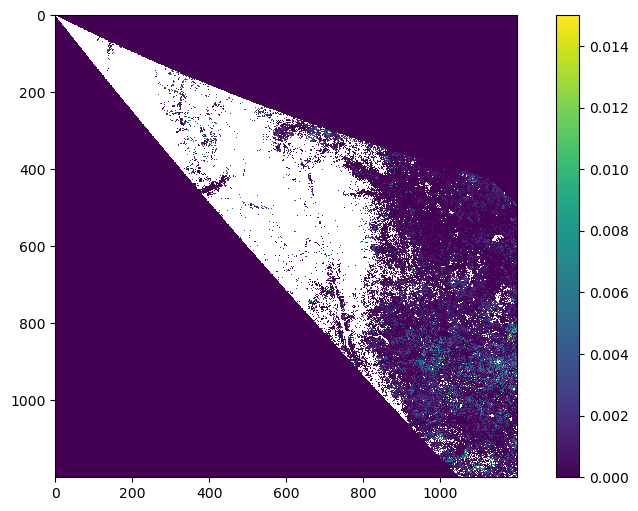

In [41]:
pyplot.figure(figsize = (10, 6))
pyplot.imshow(albers.read(1), vmin = 0.00, vmax = 0.015)
pyplot.colorbar()

Success? Well, kinda. You may have noticed that we can't see all of the original image; only the top-left portion is shown. 

It turns out that the re-projected Albers image should be larger than 1200 by 1200 pixels (the size of the resampled MODIS Sinusoidal image). But how large should it be? That's left as an additional (optional) exercise for you.

**Hints:**

1. You have the Albers coordinates of the upper-left corner of the output image. If you could figure out the coordinates of the lower-right corner, you could then figure out how wide and how tall the image is in meters.
2. You also know the pixel size of the output image (in meters).
3. With the pixel size and total distances across the horizontal and vertical axes of the image, you can easily calculate the numbers of columns and rows (pixels) required to show the whole re-projected image.